# Exploring EPL Matches – Web Scraping for Machine Learning

## 1. Introduction

In this initial part, we're going to complete the first segment of a machine learning project on the [English Premier League](https://en.wikipedia.org/wiki/Premier_League) (EPL) football matches.

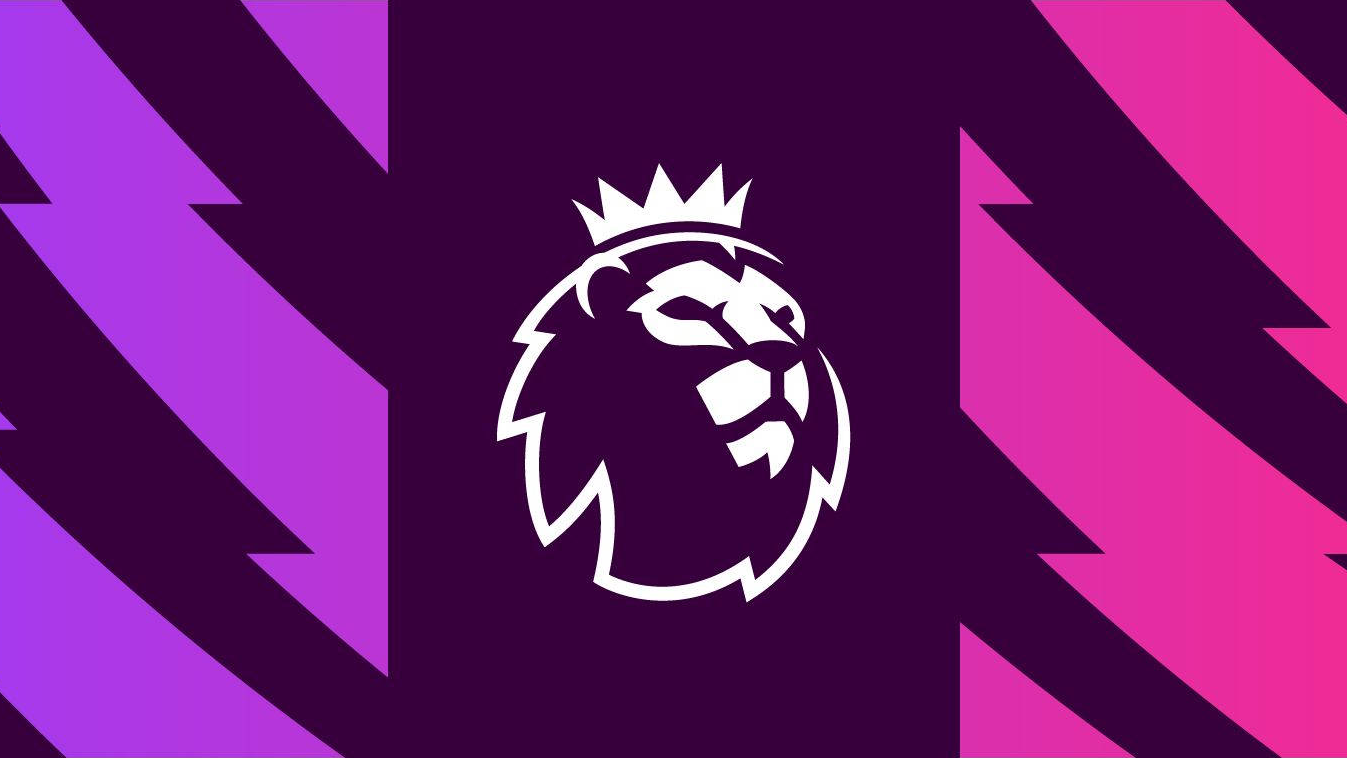

For some background, the Premier League is the top tier of professional football in England. It's renowned for its clubs like `Manchester United` and `Liverpool`, competitive matches, and global viewership. Additionally, it consists of `20` teams that compete each year for the league title.

While the ultimate goal is to predict the winner of each football match, we're going to use web scraping to gather the necessary data on the EPL match results. Then, we'll load them into [pandas](https://pandas.pydata.org/docs/) as a cleaned table ready for machine learning.

## 2. Downloading and Exploring the EPL Statistics Page

First, we need to download the web page containing the [EPL stats for 2021-2022](https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats). To do this, we'll utilize the [Requests](https://requests.readthedocs.io/en/latest) library, which is specifically designed for downloading web pages.

Once we've downloaded the HTML for the page, we'll also explore it using the web browser's inspector. Our objective is to extract the first table, which lists every team in the league along with its statistics. Specifically, we need to fetch the URL for each team to be able to retrieve their match log for the season.

In [1]:
# Import the relevant libraries
from bs4 import BeautifulSoup
import pandas as pd
import requests
import time

# Adjust the maximum number of columns displayed to show all columns
pd.set_option('display.max_columns', None)

# Define the URL for the Premier League standings webpage, then request data from it
standings_url = "https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats"
data = requests.get(standings_url)
data

<Response [200]>

The output indicates that the HTTP request was successful. The status code `200` signifies that the server has processed the request and returned the requested resource. Therefore, the webpage was successfully accessed.

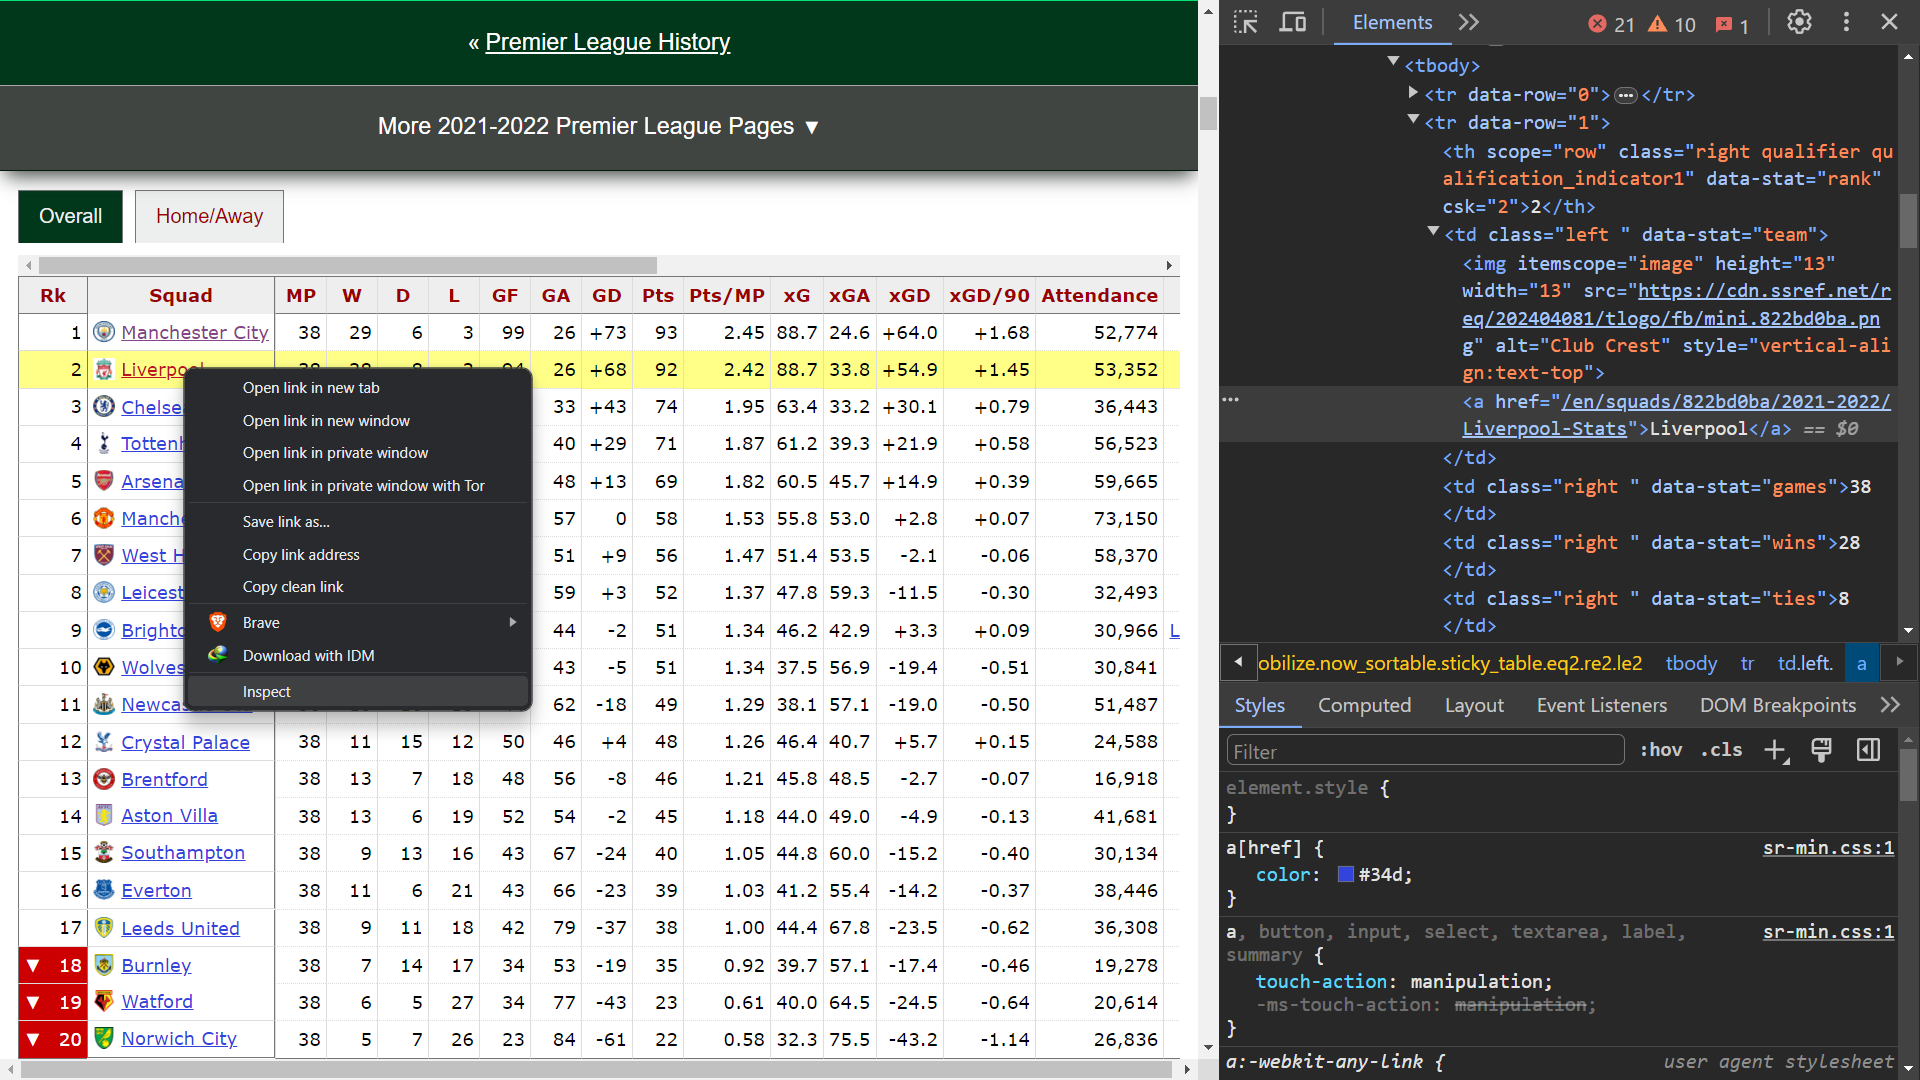

This screenshot displays the Premier League standings for the `2021-2022` season. Right-clicking on an element and selecting `Inspect` opens the developer tools for the webpage, which allows us to view the HTML code associated with the element. For example, when we right-clicked on the `Liverpool` text, we were able to view the HTML code for the row, which includes `<td>` tags used to define data cells in a table.

The text `Liverpool` is wrapped in an `<a>` tag, which creates a hyperlink. Also, the `href` attribute within the `<a>` tag specifies the URL of the linked webpage, which in this case, points to the Liverpool page. Therefore, to access the link to the `Liverpool` or any other team page, we would need to inspect the element and locate the `href` attribute within the `<a>` tag.

## 3. Parsing HTML Links

To parse the downloaded HTML and extract the necessary elements, we're going to use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), a Python library for parsing web pages. Essentially, we want to parse the full URLs for all the EPL teams from the league table.

When examining the HTML code within the developer tools, we observe that all the necessary data is enclosed within a `<table>` tag with the class `stats_table`. Initially, we will select the table containing the Premier League standings, and then extract all the `<a>` tags containing the actual links within the table.

In [2]:
# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(data.text)

# Select the table containing the Premier League standings
standings_table = soup.select('table.stats_table')[0]

# Print the extracted standings table and its type
print(type(standings_table), end='\n\n')
print(standings_table)

<class 'bs4.element.Tag'>

<table class="stats_table sortable min_width force_mobilize" data-cols-to-freeze=",2" id="results2021-202291_overall"> <caption>Regular season Table</caption> <colgroup><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/></colgroup> <thead> <tr> <th aria-label="Rank" class="poptip sort_default_asc center" data-stat="rank" data-tip="&lt;strong&gt;Rank&lt;/strong&gt;&lt;br&gt;Squad finish in competition&lt;br&gt;Finish within the league or competition.&lt;br&gt;For knockout competitions may show final round reached.&lt;br&gt;Colors and arrows represent promotion/relegation or qualifiation for continental cups.&lt;br&gt;Trophy indicates team won league whether by playoffs or by leading the table.&lt;br&gt;Star indicates topped table in league USING another means of naming champion." scope="col">Rk</th> <th aria-label="Squad" class="poptip sort_default_asc center" data-stat="team" scope="col">Squad</th

The output confirms that the extracted element is a `BeautifulSoup Tag` object. The HTML snippet shows the table structure, including headers for rank, squad, matches played, wins, draws, and losses, among other statistics.

In [3]:
# Find all <a> tags within the `standings_table` and display the first 3 links
links = standings_table.find_all('a')
links[:3]

[<a href="/en/squads/b8fd03ef/2021-2022/Manchester-City-Stats">Manchester City</a>,
 <a href="/en/players/e46012d4/Kevin-De-Bruyne">Kevin De Bruyne</a>,
 <a href="/en/players/3bb7b8b4/Ederson">Ederson</a>]

Next, let's extract only the `href` property from each link, then filter the links to get only those for the teams.

In [4]:
# Extract the href attribute from each link, and display the first 3 links
links = [l.get("href") for l in links]
links[:3]

['/en/squads/b8fd03ef/2021-2022/Manchester-City-Stats',
 '/en/players/e46012d4/Kevin-De-Bruyne',
 '/en/players/3bb7b8b4/Ederson']

In [5]:
# Filter links to include only those related to team squads, and display the first 3 links
links = [l for l in links if '/squads/' in l]
links[:3]

['/en/squads/b8fd03ef/2021-2022/Manchester-City-Stats',
 '/en/squads/822bd0ba/2021-2022/Liverpool-Stats',
 '/en/squads/cff3d9bb/2021-2022/Chelsea-Stats']

Finally, let's convert the filtered links into the full URLs by adding the domain part.

In [6]:
# Add domain to create full URLs for each team, and display the first 3 URLs
team_urls = [f"https://fbref.com{l}" for l in links]
team_urls[:3]

['https://fbref.com/en/squads/b8fd03ef/2021-2022/Manchester-City-Stats',
 'https://fbref.com/en/squads/822bd0ba/2021-2022/Liverpool-Stats',
 'https://fbref.com/en/squads/cff3d9bb/2021-2022/Chelsea-Stats']

## 4. Extracting Match Statistics

Now that we have a list of full URLs, one for each team, we can retrieve the desired statistics. The `Scores & Fixtures` table in the HTML code is enclosed within a `<table>` tag with the class `stats_table`. Also, each row in this table represents an individual match.

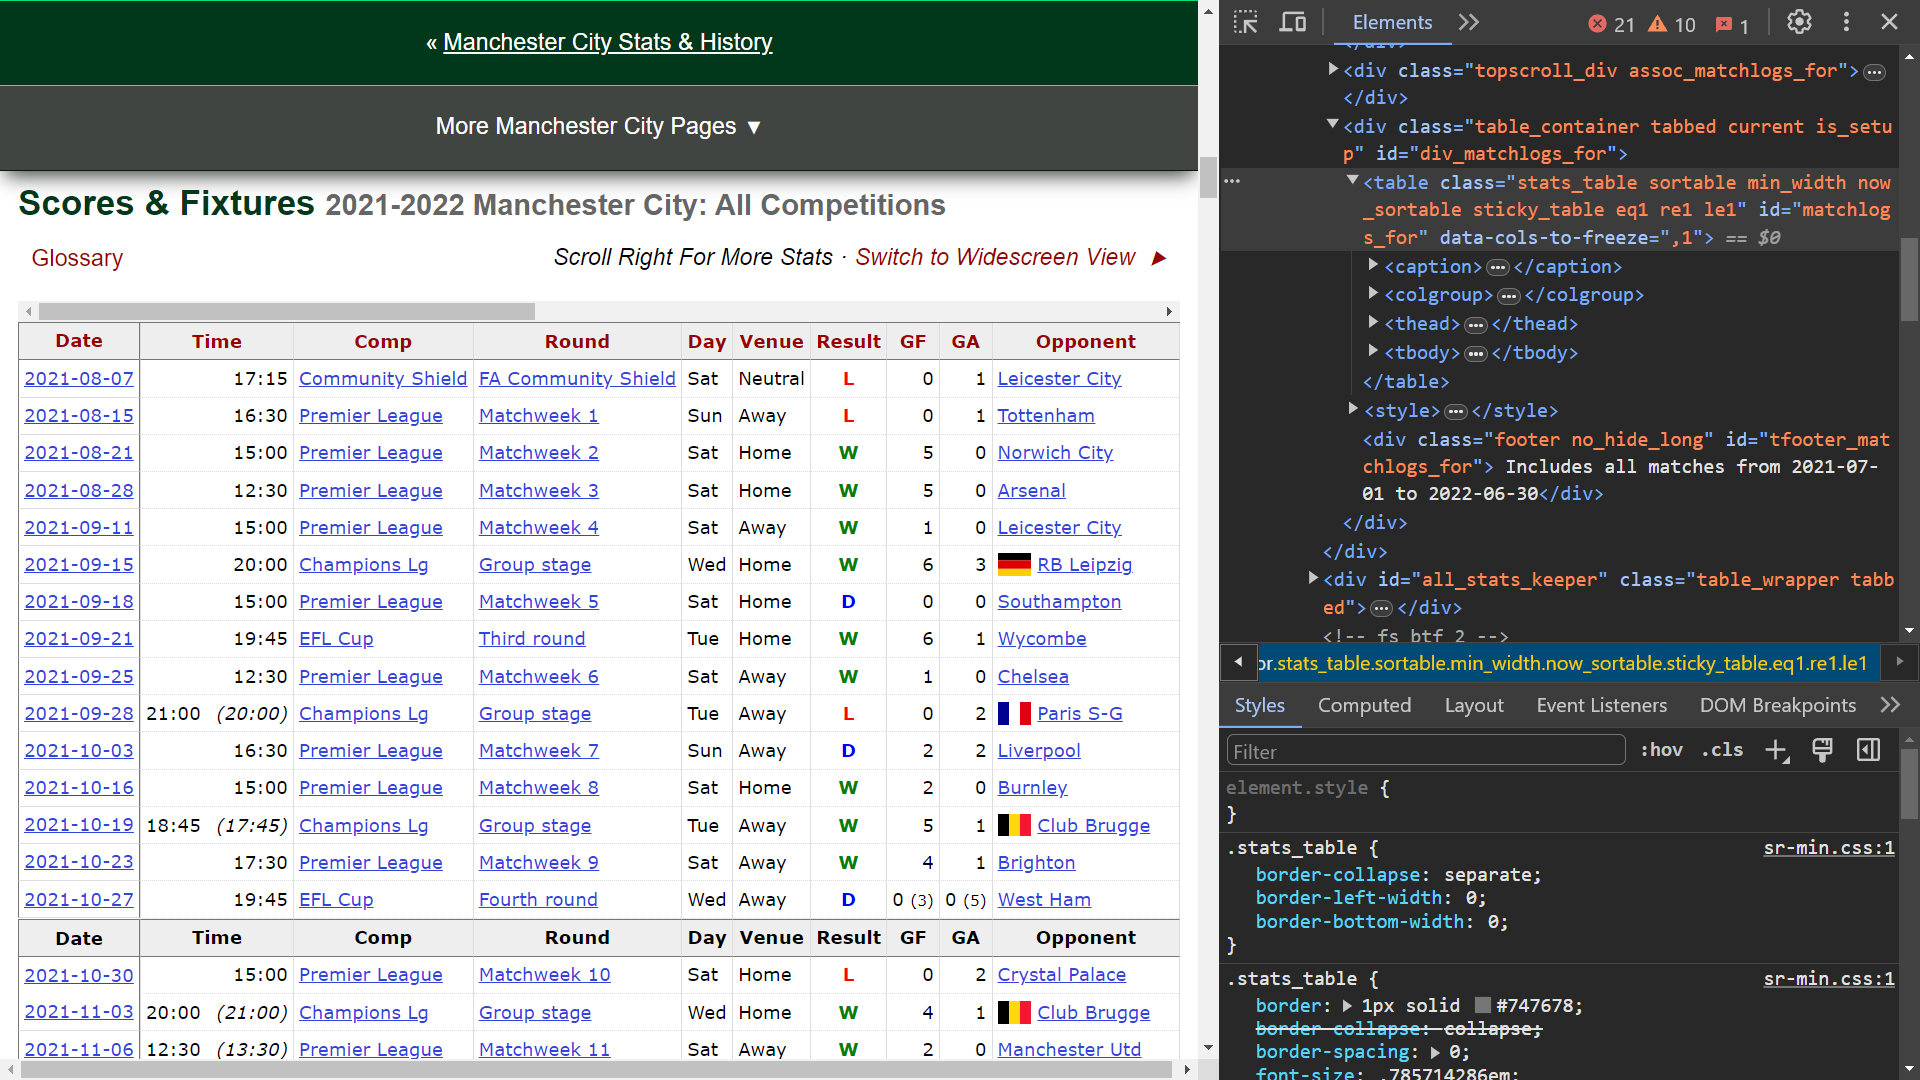

Let's begin by downloading the HTML page for `Manchester City`, parsing the table containing scores and fixtures for all the matches, and then reading it into a pandas DataFrame.

In [7]:
# Get the HTML content for Manchester City's page
data = requests.get(team_urls[0])

# Read the table containing scores and fixtures into a DataFrame
scores_fixtures = pd.read_html(data.text, match="Scores & Fixtures")[0]
scores_fixtures.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,2021-08-07,17:15,Community Shield,FA Community Shield,Sat,Neutral,L,0,1,Leicester City,NaN,NaN,57,NaN,Fernandinho,4-3-3,Paul Tierney,Match Report,NaN
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,1.8,1.0,65,58262.0,Fernandinho,4-3-3,Anthony Taylor,Match Report,NaN
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,2.6,0.1,67,51437.0,İlkay Gündoğan,4-3-3,Graham Scott,Match Report,NaN
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,4.4,0.2,80,52276.0,İlkay Gündoğan,4-3-3,Martin Atkinson,Match Report,NaN
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,2.8,0.6,61,32087.0,İlkay Gündoğan,4-3-3,Paul Tierney,Match Report,NaN


## 5. Getting Match Shooting Statistics

In the `Scores & Fixtures` table, we lack details about each match, such as the number of shots, shots on target, free kicks, and penalty kicks. Some of these statistics can be found in the table under the `Shooting` tab.

We want to download the table containing the shooting statistics for the `Manchester City` team and read it in a pandas DataFrame. But first, let's extract all the `<a>` tags containing the actual links on the page.

In [8]:
# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(data.text)

# Find all the links in the HTML, and display the first 3 links
links = soup.find_all('a')
links[:3]

[<a class="pt" href="https://fbref.com/pt/squads/b8fd03ef/2021-2022/Manchester-City-Stats" onclick="sr_set_trans_choice('pt');">Português</a>,
 <a class="en" href="https://fbref.com/en/squads/b8fd03ef/2021-2022/Manchester-City-Stats" onclick="sr_set_trans_choice('en');">English</a>,
 <a class="fr" href="https://fbref.com/fr/squads/b8fd03ef/2021-2022/Manchester-City-Stats" onclick="sr_set_trans_choice('fr');">Français</a>]

Next, let's extract only the `href` property from each link, then filter the links to get only those for the shooting statistics.

In [9]:
# Extract href attributes from the links
links = [l.get("href") for l in links]

# Filter out links that are not null and contain 'all_comps/shooting/'
links = [l for l in links if (pd.isnull(l) == False and 'all_comps/shooting/' in l)]
links

['/en/squads/b8fd03ef/2021-2022/matchlogs/all_comps/shooting/Manchester-City-Match-Logs-All-Competitions',
 '/en/squads/b8fd03ef/2021-2022/matchlogs/all_comps/shooting/Manchester-City-Match-Logs-All-Competitions',
 '/en/squads/b8fd03ef/2021-2022/matchlogs/all_comps/shooting/Manchester-City-Match-Logs-All-Competitions',
 '/en/squads/b8fd03ef/2021-2022/matchlogs/all_comps/shooting/Manchester-City-Match-Logs-All-Competitions']

Finally, let's retrieve the HTML of this link that appeared four times on the page, and convert it into the full URL by adding the domain part.

In [10]:
# Retrieve the HTML content of the shooting stats page and add the domain part
data = requests.get(f"https://fbref.com{links[0]}")

## 6. Cleaning and Merging Scraped Data

Soon, we're going to have two DataFrames for `Manchester City` – one containing scores and fixtures and the other containing shooting statistics. Since both will refer to the same matches, we can combine these DataFrames after performing some basic cleaning.

In [11]:
# Read the HTML table containing shooting statistics and display the first few rows
shooting = pd.read_html(data.text, match="Shooting")[0]
shooting.head()

For Manchester City                                                     \
                 Date   Time              Comp                Round  Day   
0          2021-08-07  17:15  Community Shield  FA Community Shield  Sat   
1          2021-08-15  16:30    Premier League          Matchweek 1  Sun   
2          2021-08-21  15:00    Premier League          Matchweek 2  Sat   
3          2021-08-28  12:30    Premier League          Matchweek 3  Sat   
4          2021-09-11  15:00    Premier League          Matchweek 4  Sat   

                                        Standard                            \
     Venue Result GF GA        Opponent      Gls  Sh SoT  SoT%  G/Sh G/SoT   
0  Neutral      L  0  1  Leicester City        0  12   3  25.0  0.00  0.00   
1     Away      L  0  1       Tottenham        0  18   4  22.2  0.00  0.00   
2     Home      W  5  0    Norwich City        4  16   4  25.0  0.25  1.00   
3     Home      W  5  0         Arsenal        5  25  10  40.0  0.20  0.50   
4     Away      W  1  0  Leicester City        1  25   8  32.0  0.04  0.13   

                      Expected                           Unnamed: 25_level_0  
   Dist   FK PK PKatt       xG npxG npxG/Sh G-xG np:G-xG        Match Report  
0   NaN  NaN  0     0      NaN  NaN     NaN  NaN     NaN        Match Report  
1  17.3  1.0  0     0      1.8  1.8    0.10 -1.8    -1.8        Match Report  
2  18.5  1.0  0     0      2.6  2.6    0.17  1.4     1.4        Match Report  
3  14.8  0.0  0     0      4.4  4.4    0.18  0.6     0.6        Match Report  
4  14.3  0.0  0     0      2.8  2.8    0.12 -1.8    -1.8        Match Report

The issue with this dataset is that it has a multi-level index. In this case, the second level of indices is not very useful. Also, we only want to be able to index based on the DataFrame's headings. Hence, let's drop the top index level.

In [12]:
# Drop the top level of the multi-level index in the columns
shooting.columns = shooting.columns.droplevel()

Now that we're ready to combine the `scores_fixtures` and `shooting` datasets, we decided not to merge all the columns in the `shooting` DataFrame because many of them already exist in the other DataFrame such as `Time`, `Comp`, and `Round`.

In [13]:
# Merge the `scores_fixtures` DataFrame with `shooting` on the "Date" column
man_city = scores_fixtures.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]],
                                 on="Date")

# Display the first 5 rows of the merged dataset
man_city.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt
0,2021-08-07,17:15,Community Shield,FA Community Shield,Sat,Neutral,L,0,1,Leicester City,NaN,NaN,57,NaN,Fernandinho,4-3-3,Paul Tierney,Match Report,NaN,12,3,NaN,NaN,0,0
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,1.8,1.0,65,58262.0,Fernandinho,4-3-3,Anthony Taylor,Match Report,NaN,18,4,17.3,1.0,0,0
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,2.6,0.1,67,51437.0,İlkay Gündoğan,4-3-3,Graham Scott,Match Report,NaN,16,4,18.5,1.0,0,0
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,4.4,0.2,80,52276.0,İlkay Gündoğan,4-3-3,Martin Atkinson,Match Report,NaN,25,10,14.8,0.0,0,0
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,2.8,0.6,61,32087.0,İlkay Gündoğan,4-3-3,Paul Tierney,Match Report,NaN,25,8,14.3,0.0,0,0


After we've combined our data, let's display the shapes of the first two DataFrames and the merged one for comparison.

In [14]:
# Print the shapes of the first two DataFrames and the merged one
print(f"Scores and fixtures: {scores_fixtures.shape}")
print(f"Shooting: {shooting.shape}")
print(f"Man City: {man_city.shape}")

Scores and fixtures: (58, 19)
Shooting: (59, 26)
Man City: (58, 25)


The DataFrames `scores_fixtures` and `man_city` have the same number of rows, but the `shooting` DataFrame has one additional row compared to the other two, suggesting that there is one match in the shooting data that is not present in the scores and fixtures data.

So far, we've scraped the Premier League standings, downloaded the data for a single team – `Manchester City`, and combined the data for this team for the `2021-2022` season into one DataFrame.

## 7. Scraping Data for Multiple Seasons and Teams

Let's scale up our approach and scrape the data for multiple teams and two seasons – `2020-2021` and `2021-2022`. To do so, we'll iterate through both the seasons and the teams, and then scrape the necessary information for each match.

In addition, we'll filter only the matches for the Premier League and add two new columns to each DataFrame we get, indicating the team's name and season. Adding such columns is crucial for distinguishing which season and team each row is related to. Moreover, preserving this data is important as we'll need it for making predictions in the future.

It's worth noting we should assign a **sleep time** after each iteration to avoid scraping too quickly, overloading the website, and thus getting blocked from scraping it.

In [15]:
# Scrape match data for multiple seasons and teams, and initialize a list to store the data
matches = list()
seasons = ['2021-2022', '2020-2021']
standings_url = "https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats"

# Iterate through each season
for season in seasons:
    
    # Request data and parse HTML for standings table
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    # Extract team URLs from standings table
    links = standings_table.find_all('a')
    links = [l.get("href") for l in links]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    # Update standings URL for the previous season
    previous_season = soup.select('a.prev')[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    # Iterate through each team URL
    for team_url in team_urls:
        
        # Extract team name from URL
        team_name = team_url.split("/")[-1]
        team_name = team_name.replace("-Stats", "").replace("-", " ")
        
        # Scrape scores and fixtures data
        data = requests.get(team_url)
        scores_fixtures = pd.read_html(data.text, match="Scores & Fixtures")[0]
        
        # Scrape shooting data
        soup = BeautifulSoup(data.text)
        links = soup.find_all('a')
        links = [l.get("href") for l in links]
        links = [l for l in links if (l and 'all_comps/shooting/' in l)]
        
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        
        # Merge scores and fixtures with shooting data
        try:
            team_data = scores_fixtures.merge(
                shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
            
        # Filter for Premier League matches, then add season and team columns
        team_data = team_data[team_data["Comp"] == "Premier League"]
        team_data["Team"] = team_name
        team_data["Season"] = season
        matches.append(team_data)
        time.sleep(3)
        
# Check the number of all the individual DataFrames
len(matches)

40

Finally, we will combine all the individual DataFrames in the `matches` list into a single one, then export it to a CSV file.

In [16]:
# Concatenate all the DataFrames in the list into a single one, then convert column names to lowercase
matches_df = pd.concat(matches)
matches_df.columns = [c.lower() for c in matches_df.columns]
matches_df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,fk,pk,pkatt,team,season
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,1.8,1.0,65.0,58262.0,Fernandinho,4-3-3,Anthony Taylor,Match Report,NaN,18.0,4.0,17.3,1.0,0,0,Manchester City,2021-2022
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,2.6,0.1,67.0,51437.0,İlkay Gündoğan,4-3-3,Graham Scott,Match Report,NaN,16.0,4.0,18.5,1.0,0,0,Manchester City,2021-2022
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,4.4,0.2,80.0,52276.0,İlkay Gündoğan,4-3-3,Martin Atkinson,Match Report,NaN,25.0,10.0,14.8,0.0,0,0,Manchester City,2021-2022
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,2.8,0.6,61.0,32087.0,İlkay Gündoğan,4-3-3,Paul Tierney,Match Report,NaN,25.0,8.0,14.3,0.0,0,0,Manchester City,2021-2022
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0,0,Southampton,1.0,0.4,64.0,52698.0,Fernandinho,4-3-3,Jonathan Moss,Match Report,NaN,16.0,1.0,16.4,1.0,0,0,Manchester City,2021-2022


In [17]:
# Export the combined DataFrame to a CSV file
matches_df.to_csv("matches.csv")

## 8. Conclusion

In this initial part, we've collected all the necessary data on EPL football matches to proceed with predicting which team will win each match in the EPL.

We've scraped web data for multiple teams and two seasons using `requests`, parsed the data using `Beautiful Soup`, read the parsed data into `pandas`, combined it into a single `DataFrame`, and exported it to a `CSV` file. The merged DataFrame includes matches of EPL teams for the `2020-2021` and `2021-2022` seasons, along with scores and fixtures data and shooting statistics.

To build upon this work, we're going to use machine learning to predict the winner of each match.